In [1]:
# imports
import numpy as np
import networkx as nx
import bct
import csv
import matplotlib.pyplot as plt
import matplotlib as mpl
import nibabel as nib
import os
import random
import pickle
from concurrent.futures import ThreadPoolExecutor
import threading

# important filepaths
pklFile = "subjectsData.pkl"
validScales = [7, 12, 20, 36, 64, 122, 197, 325, 444]
# SCALES_TO_COMPUTE = [7, 64, 197]
SCALES_TO_COMPUTE = [197]

**Generating Subjects and Graphs for Subjects**

In [ ]:
# Define classes and create Subjects from subjects.csv to fill them with phenotypic stats
class Subject:
    def __init__(self, id, age, gender, handedness, subject_type, diagnosis, index):
        self.id = id
        self.age = int(age)
        self.gender = gender
        self.handedness = handedness
        self.subject_type = subject_type
        self.diagnosis = diagnosis
        self.index = index  #subject's index in the list of all subjects
        self.scales = {}

    def createGraphs(self, scales=SCALES_TO_COMPUTE):
        assert all(scale in validScales for scale in scales)

        for scale in scales:
            np_arr = np.load(f'functional connectomes/connectomes_cobre_scale_{scale}.npy') #load nparray for the scale
            subject_arr = np_arr[:, :, self.index]
            np.fill_diagonal(subject_arr, 0)  # remove the 1.0 self edges
            self.scales[scale] = Graphs(scale=scale, adj_mtx=subject_arr)

THRESHOLDS_POS = [round(x * 0.01, 2) for x in range(37, 51)]  #thresholds between 37%-50% inclusive
THRESHOLDS_NEG = np.linspace(0.0965, 0.1305, 5) 
# these thresholds for negative graphs were calculate to match the ratio of selected positive edges to average positive edges. 5 intervals
# was arbitrary and chosen to save computation time

# # Store weighted graphs for each subject
class Graphs:
    def __init__(self, scale, adj_mtx):
        self.scale = scale

        # get nodes with roi info csv calculated in mask_prep.ipynb
        node_attributes = {}
        with open(f'Parcel_Information/nodes_{scale}.csv', newline="") as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                node_id = int(row['roi'])
                node_attributes[node_id] = {k: row[k] for k in row if k != 'ID'}

        # original graph
        G = nx.from_numpy_array(adj_mtx)
        G = nx.relabel_nodes(G, {i: i + 1 for i in G.nodes})    #relabel nodes indices to fit rois because rois start at 1
        nx.set_node_attributes(G, node_attributes)
        # self.original = G

        # positive edges graph
        positive_edges = [(u, v, d) for u, v, d in G.edges(data=True) if d['weight'] > 0]
        G_pos = nx.Graph()
        G_pos.add_edges_from(positive_edges)
        G_pos.add_nodes_from((n, G.nodes[n]) for n in G.nodes)
        # self.pos = G_pos

        # negative edges graph
        #keep in mind negative weights are made positive here
        negative_edges = [(u, v, {'weight': abs(d['weight'])}) for u, v, d in G.edges(data=True) if d['weight'] < 0]

        G_neg = nx.Graph()
        G_neg.add_edges_from(negative_edges)
        G_neg.add_nodes_from((n, G.nodes[n]) for n in G.nodes)
        # self.neg = G_neg

        # positive and negative thresholded graphs
        self.pos_thresh = get_thresh_graphs(G_pos, True)
        self.neg_thresh = get_thresh_graphs(G_neg, False)

# Helper function: input = Graph, output = dict {threshold : thresholded graph}
# Assumes G has positive value edges only (even if it represents a negative network)
def get_thresh_graphs(G, boolPositiveThresh):
    thresh_graphs = {}
    N = G.number_of_nodes()
    edges_sorted = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)   # Sort edges by weight
    if boolPositiveThresh:
        thresholds = THRESHOLDS_POS
    else:
        thresholds = THRESHOLDS_NEG
    for i, threshold in enumerate(thresholds):
        target_num_edges = int((threshold * N * (N - 1)) / 2)
        edges_to_keep = edges_sorted[:target_num_edges]
        G_thresh = nx.Graph()
        G_thresh.add_edges_from(edges_to_keep)
        G_thresh.add_nodes_from((n, G.nodes[n]) for n in G.nodes)
        thresh_graphs[i] = G_thresh
    return thresh_graphs



In [3]:
subjects_list = []

def loadSubjectsPickle():
    # Use this to load in the subjects pickle file (subjectsData.pkl) anytime
    with open(pklFile, 'rb') as f:
        global subjects_list
        subjects_list = pickle.load(f)

def saveSubjectsPickle():
    with open(pklFile, 'wb') as f:
        pickle.dump(subjects_list, f)

In [4]:
loadSubjectsPickle()

In [281]:
saveSubjectsPickle()

In [ ]:
# Read in subjects from csv file and Calculate graphs
subjects_csv_filepath = 'subjects.csv'

with open('subjects.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader, None)
    subjects_list = [Subject(row[0], row[1], row[2], row[3], row[4], row[5], index) for index, row in enumerate(reader)]

# Calculate graphs
def process_subject_graphs(subj):
    # print(subj.id)
    subj.createGraphs()

with ThreadPoolExecutor(max_workers=5) as executor:
    executor.map(process_subject_graphs, subjects_list)

# for subject in subjects_list[:20]:
#     process_subject_graphs(subject)

saveSubjectsPickle()

**Sanity checks**

In [6]:
# sanity checks
# print(x)
# np_test = np.load(f'functional connectomes/connectomes_cobre_scale_{197}.npy')
# np_test = np.triu(np_test[:, :, 0], k=1)
# sorted_arr = np.sort(np_test, axis=None)
# # print(sorted_arr[-7:])

# print(subjects_list[0].scales)
# # print(subjects_list[0].scales[197].pos_thresh)
# weights = nx.get_edge_attributes(subjects_list[0].scales[197].pos_thresh[50], 'weight')
# print(len(weights))
# print(weights)
# # print(subjects_list[0].scales[7].pos_thresh.graphs[50])
# process_subject_graphs(subjects_list[0])
subj = subjects_list[5]
graph = subj.scales[197].neg_thresh
print(graph[0])
print(THRESHOLDS_POS)


Graph with 197 nodes and 1863 edges
[0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5]


**Calculating metrics**

In [259]:
# All metrics are weighted
# Metrics dictionary is for each graph or thresholded graphs
def calc_metrics(G):
    # print(G)
    degrees = [G.degree(node, weight='weight') for node in G]
    edge_weights = [G[i][j]['weight'] for i,j in G.edges()]
    max_w = max(edge_weights)
    
    def connectivity_strength():
        return np.mean(edge_weights) if edge_weights else 0

    def average_clustering():
        return nx.average_clustering(G, weight='weight')

    def average_spl():
        # invert weights
        # initialize graph with inverted edge weights
        inv_G = nx.Graph()

        # add edges from original graph, with weights transformed as described above
        for e,f in G.edges():
            inv_G.add_edge(e,f,weight=(2*max_w)-G[e][f]["weight"])
            
        new_G = inv_G
        if not nx.is_connected(new_G):
            connected_components = nx.connected_components(new_G)
            # Find the largest connected component
            largest_component = max(connected_components, key=len)
            # Create a subgraph from the largest connected component
            new_G = new_G.subgraph(largest_component).copy()

        # calculate weighted average shortest path
        return nx.average_shortest_path_length(new_G,weight='weight')

    def degree_assortativity_coefficient():
        return nx.degree_assortativity_coefficient(G, weight='weight')
    
    def largest_connected_component_size(graph):
        if len(list(nx.connected_components(graph))) == 0:
            return 0
        largest_cc = max(nx.connected_components(graph), key=len)
        return len(largest_cc)

    def robustness(attack_type):
        G_copy = G.copy()

        if attack_type == 'r':
            attack_order = list(G_copy.nodes())
            random.shuffle(attack_order)  # Randomize node order, TODO: update to true random?
        elif attack_type == 't':
            attack_order = sorted(G_copy.nodes(), key=lambda node: G_copy.degree(node), reverse=True)

        sizes = []
        for node in attack_order:
            G_copy.remove_node(node)
            largest_cc = largest_connected_component_size(G_copy)
            sizes.append(largest_cc)
            if largest_cc == 0:
                break

        nodes_removed = np.arange(len(sizes))
        return np.trapz(sizes, nodes_removed)

    return {
        'connectivity_strength': connectivity_strength(),
        'degrees': degrees,
        'degrees_mean': np.mean(degrees),
        'degrees_variance': np.var(degrees),
        'average_clustering': average_clustering(),
        'global_efficiency': nx.global_efficiency(G),
        'average_spl': average_spl(),
        'degree_assortativity_coefficient': degree_assortativity_coefficient(),
        # 'small_worldness': nx.sigma(G, niter=1, nrand=1),
        'robustness_random': robustness('r'),
        'robustness_targeted': robustness('t'),
    }

# Gs is a dict of threshold:graph
def calc_metrics_avg(Gs_dict):
    # mean of each metric that can be averaged
    averages = {}
    for stat in [
                 'connectivity_strength', 
                 'degrees_mean', 
                 'degrees_variance',
                 'average_clustering', 
                 'global_efficiency',
                 'average_spl',
                 'degree_assortativity_coefficient',
                 'robustness_random',
                 'robustness_targeted']:
        averages[stat] = np.mean([metrics[stat] for metrics in Gs_dict.values()])

    return averages
        

def calc_metrics_subject(subj):
    # Calculate metrics for a subject
    print(subj.id)
    subj.metrics = {}
    for scale in SCALES_TO_COMPUTE:
        d = {}
        graphs = subj.scales[scale]
        # d['pos'] = calc_metrics(graphs.pos)
        # d['neg'] = calc_metrics(graphs.neg)
        d['pos_thresh'] = {threshold:calc_metrics(graphs.pos_thresh[threshold]) for threshold in graphs.pos_thresh.keys()}
        d['neg_thresh'] = {threshold:calc_metrics(graphs.neg_thresh[threshold]) for threshold in graphs.neg_thresh.keys()}
        d['pos_thresh_avg'] = calc_metrics_avg(d['pos_thresh'])
        d['neg_thresh_avg'] = calc_metrics_avg(d['neg_thresh'])
        subj.metrics[scale] = d

# for subject in [subjects_list[20]]:
#     calc_metrics_subject(subj) 

# with ThreadPoolExecutor(max_workers=5) as executor:
#     executor.map(calc_metrics_subject, [subjects_list[20], subjects_list[100]])
# calc_metrics_subject(subjects_list[20])


In [271]:
print('saving to pickle')
saveSubjectsPickle()

saving to pickle


In [10]:
subj = subjects_list[120]
metrics = subj.metrics
print(metrics[197]['pos_thresh_avg'])
# print(subj.scales[197].pos_thresh[13].number_of_edges())

{'connectivity_strength': 0.527792561938662, 'degrees_mean': 44.86488496714927, 'degrees_variance': 259.11635724902607, 'average_clustering': 0.38578994692637664, 'global_efficiency': 0.7130283948241932, 'average_spl': 2.163247838632544, 'degree_assortativity_coefficient': 0.14217480398186524, 'robustness_random': 19173.14285714286, 'robustness_targeted': 19101.428571428572, 'small_worldness': 1.4514818300906993}


In [8]:
patients_list = [subj for subj in subjects_list if subj.id.startswith('s')]
controls_list = [subj for subj in subjects_list if subj.id.startswith('c')]

**Null model per sz/control group and calculate small worldness**

In [116]:
np_arr = np.load(f'functional connectomes/connectomes_cobre_scale_{197}.npy') #load nparray for the scale
for i in range(len(subjects_list)):
    np.fill_diagonal(np_arr[:, :, i], 0) 

patients_matrices = [np_arr[:, :, subj.index] for subj in patients_list]
controls_matrices = [np_arr[:, :, subj.index] for subj in controls_list]
avg_patient_mtx = np.mean(patients_matrices, axis=0)
avg_control_mtx = np.mean(controls_matrices, axis=0)

patient_null_subject = Subject(None, 0, None, None, 'Patient', None, None)
control_null_subject = Subject(None, 0, None, None, 'Control', None, None)
patient_null_subject.scales[197] = Graphs(scale=197, adj_mtx=avg_patient_mtx)
control_null_subject.scales[197] = Graphs(scale=197, adj_mtx=avg_control_mtx)

In [145]:
def null(G):
    # First null model: DP double edge swaps, weighted graph 
    # Create an ensemble of random graphs via DP double edge swaps and measure average clustering and average shortest 
    # path length

    # initialise lists to store metrics from random graphs
    wclustering_DP = []
    wshort_path_DP = []

    # Create list of edge weights
    edge_weights = [G[i][j]['weight'] for i,j in G.edges()]
    # identify max edge weight
    max_w = max(edge_weights)

    # ensemble of 100 graphs generated from DP double edge swaps    #TODO: set to 5 for now
    for i in range(5): 
        
        WDP = G.copy() # the function edits the graph in place, so create a copy first
        
        #function to shuffle graph and enforce connectedness
        nx.connected_double_edge_swap(WDP,nswap=10*G.number_of_edges())
        
        # double edge swap function loses the edge weight info - randomly assign the same edge weights from
        # the real data
        random.shuffle(edge_weights)
        count = 0
        for e,f in WDP.edges():
            WDP[e][f]['weight']=edge_weights[count]
            count+=1
        
        # weighted average clustering
        WC_DP = nx.average_clustering(WDP,weight='weight')
        wclustering_DP.append(WC_DP)
        
        # weighted average path length -> need to transform the weights the same way as for the real data
        
        # initialize graph with inverted edge weights
        WDP_inv = nx.Graph()

        # add edges from original graph, with weights transformed as described above
        for e,f in WDP.edges():
            WDP_inv.add_edge(e,f,weight=(2*max_w)-WDP[e][f]["weight"])
            
        # calculate weighted average shortest path
        wd_DP = nx.average_shortest_path_length(WDP_inv,weight='weight')
        wshort_path_DP.append(wd_DP)
        # break
        
    # calculate mean and standard deviations of metrics
    print("Average weighted clustering in DP graphs:", np.mean(wclustering_DP), "+/-",np.std(wclustering_DP))
    print("Average weighted shortest path in DP graphs:", np.mean(wshort_path_DP), "+/-",np.std(wshort_path_DP))
    return (np.mean(wclustering_DP), np.mean(wshort_path_DP))

def calcNull(threshGraphs):
    clustering_list = []
    spl_list = []
    # for i in range(2):
    for i in threshGraphs.keys():
        null_clustering, null_spl = null(threshGraphs[i])
        clustering_list.append(null_clustering)
        spl_list.append(null_spl)
    return (clustering_list, spl_list)

In [146]:
patient_pos_thresh = patient_null_subject.scales[197].pos_thresh
control_pos_thresh = control_null_subject.scales[197].pos_thresh
# Global variables for results
patient_pos_clustering_list, patient_pos_spl_list = None, None
control_pos_clustering_list, control_pos_spl_list = None, None

def t0():
    global patient_pos_clustering_list, patient_pos_spl_list
    patient_pos_clustering_list, patient_pos_spl_list = calcNull(patient_pos_thresh)

def t2():
    global control_pos_clustering_list, control_pos_spl_list
    control_pos_clustering_list, control_pos_spl_list = calcNull(control_pos_thresh)


# Execute the threads
threads = []
for func in [t0, t2]:
    thread = threading.Thread(target=func)
    threads.append(thread)
    thread.start()

# Wait for threads to finish
for thread in threads:
    thread.join()


Average weighted clustering in DP graphs: 0.18544278665103184 +/- 0.0005414645459353947
Average weighted shortest path in DP graphs: 1.9567961958080111 +/- 0.001723540117729064
Average weighted clustering in DP graphs: 0.20579462071501395 +/- 0.0009370876999211482
Average weighted shortest path in DP graphs: 1.8774190081302158 +/- 0.0014678361578431174
Average weighted clustering in DP graphs: 0.18798179379516647 +/- 0.0004853511973306488
Average weighted shortest path in DP graphs: 1.9478485426276335 +/- 0.0011903723528387973
Average weighted clustering in DP graphs: 0.20877816196454452 +/- 0.0005503348475809752
Average weighted shortest path in DP graphs: 1.869038833842789 +/- 0.0016670080432810456
Average weighted clustering in DP graphs: 0.19028749246672524 +/- 0.0006522873553883847
Average weighted shortest path in DP graphs: 1.9390728534701709 +/- 0.0008579243537876363
Average weighted clustering in DP graphs: 0.21097120728867944 +/- 0.0004441177224271644
Average weighted shortes

In [156]:
print(patient_pos_clustering_list, patient_pos_spl_list)
print(control_pos_clustering_list, control_pos_spl_list)
print(np.mean(patient_pos_clustering_list), np.mean(patient_pos_spl_list))
print(np.mean(control_pos_clustering_list), np.mean(control_pos_spl_list))

patient_mean_cluster_null = np.mean(patient_pos_clustering_list)
control_mean_cluster_null = np.mean(control_pos_clustering_list)
patient_mean_spl_null = np.mean(patient_pos_spl_list)
control_mean_spl_null = np.mean(control_pos_spl_list)

[0.18544278665103184, 0.18798179379516647, 0.19028749246672524, 0.19359875290963488, 0.195691320997087, 0.19724411050518892, 0.19981993515336643, 0.2014990080583426, 0.20310131129090547, 0.20489354308969535, 0.20715122750915366, 0.20851133916934012, 0.21021959221022496, 0.21153222504421568] [1.9567961958080111, 1.9478485426276335, 1.9390728534701709, 1.9302083573200448, 1.9209813272230822, 1.9153115213403749, 1.906278857466117, 1.8966991277099097, 1.8879331223720102, 1.879833880259369, 1.8715862884661454, 1.8634833406957452, 1.8550519183888774, 1.8475631173627058]
[0.20579462071501395, 0.20877816196454452, 0.21097120728867944, 0.21527950589208392, 0.21757472016502502, 0.2205737113582758, 0.2228997661465782, 0.2265585899740563, 0.22810793636244014, 0.23078879080045983, 0.233632201543608, 0.23641470858742958, 0.23895523347228048, 0.24111162234320888] [1.8774190081302158, 1.869038833842789, 1.8605036453000152, 1.850997846306098, 1.843761992264708, 1.8357467189914956, 1.8295108399984013, 1

In [245]:
np_arr = np.load(f'functional connectomes/connectomes_cobre_scale_{197}.npy') #load nparray for the scale
for i in range(len(subjects_list)):
    np.fill_diagonal(np_arr[:, :, i], 0) 

patients_matrices = [np_arr[:, :, subj.index] for subj in patients_list]
controls_matrices = [np_arr[:, :, subj.index] for subj in controls_list]
avg_patient_mtx = np.mean(patients_matrices, axis=0)
avg_control_mtx = np.mean(controls_matrices, axis=0)

patient_null_subject = Subject(None, 0, None, None, 'Patient', None, None)
control_null_subject = Subject(None, 0, None, None, 'Control', None, None)
patient_null_subject.scales[197] = Graphs(scale=197, adj_mtx=avg_patient_mtx)
control_null_subject.scales[197] = Graphs(scale=197, adj_mtx=avg_control_mtx)

In [ ]:
# # Calculate small worldness
# for subj in subjects_list:
#     print(subj.id)
#     d = subj.metrics[197]
#     avgs_dict = d['pos_thresh_avg']
#     # print(avgs_dict)
#     if subj.subject_type == 'Control':
#         small_worldness = (avgs_dict['average_clustering'] * control_mean_spl_null) / (avgs_dict['average_spl'] * control_mean_cluster_null)
#     elif subj.subject_type == 'Patient':
#         small_worldness = (avgs_dict['average_clustering'] * patient_mean_spl_null) / (avgs_dict['average_spl'] * patient_mean_cluster_null)
#     subj.metrics[197]['pos_thresh_avg']['small_worldness'] = small_worldness

print(np_arr[:, :, 20])
subjects_list[20].createGraphs([197])
print(nx.is_connected(subjects_list[20].scales[197].pos_thresh[7]))

# for subj in subjects_list:
#     if (not hasattr(subj, 'metrics')) or (not subj.metrics):
#         print(subj.id)


[[ 0.         -0.14474266 -0.21667889 ...  0.24560797 -0.127377
  -0.19858305]
 [-0.14474266  0.          0.20950788 ...  0.32304902  0.71723602
   0.71319024]
 [-0.21667889  0.20950788  0.         ...  0.00683042  0.308785
   0.23907561]
 ...
 [ 0.24560797  0.32304902  0.00683042 ...  0.          0.35239701
   0.26727499]
 [-0.127377    0.71723602  0.308785   ...  0.35239701  0.
   0.5702645 ]
 [-0.19858305  0.71319024  0.23907561 ...  0.26727499  0.5702645
   0.        ]]
False


**Subject 20: contxxx0040013 broken, graph says not connected**

In [12]:
new_subjects_list = subjects_list[:20] + subjects_list[20 + 1:]
patients_list = [subj for subj in new_subjects_list if subj.id.startswith('s')]
controls_list = [subj for subj in new_subjects_list if subj.id.startswith('c')]

In [236]:
print(new_subjects_list[0].metrics[197]['neg_thresh_avg'])

{'connectivity_strength': 0.2576956444686662, 'degrees_mean': 5.701490008616695, 'degrees_variance': 18.913984764545972, 'average_clustering': 0.010177070358506492, 'global_efficiency': 0.5170137090368774, 'average_spl': 2.0843697540890616, 'degree_assortativity_coefficient': -0.3518495972600426, 'robustness_random': 18834.3, 'robustness_targeted': 11945.1}


In [251]:


# Calculate small worldness
for subj in new_subjects_list:
    print(subj.id)
    d = subj.metrics[197]
    avgs_dict = d['neg_thresh_avg']
    # print(avgs_dict)
    if subj.subject_type == 'Control':
        small_worldness = (avgs_dict['average_clustering'] * control_mean_spl_null) / (avgs_dict['average_spl'] * control_mean_cluster_null)
    elif subj.subject_type == 'Patient':
        small_worldness = (avgs_dict['average_clustering'] * patient_mean_spl_null) / (avgs_dict['average_spl'] * patient_mean_cluster_null)
    subj.metrics[197]['neg_thresh_avg']['small_worldness'] = small_worldness

contxxx0040086
contxxx0040087
szxxx0040110
contxxx0040067
szxxx0040072
szxxx0040073
szxxx0040071
szxxx0040077
szxxx0040075
szxxx0040078
szxxx0040079
szxxx0040092
szxxx0040094
szxxx0040096
szxxx0040097
contxxx0040091
szxxx0040099
contxxx0040093
contxxx0040095
szxxx0040143
szxxx0040145
szxxx0040142
contxxx0040014
contxxx0040017
contxxx0040019
contxxx0040018
szxxx0040060
szxxx0040029
contxxx0040054
szxxx0040082
szxxx0040081
szxxx0040080
szxxx0040085
szxxx0040084
szxxx0040089
szxxx0040088
contxxx0040024
contxxx0040026
contxxx0040027
contxxx0040020
contxxx0040023
contxxx0040147
contxxx0040146
contxxx0040144
contxxx0040141
contxxx0040140
szxxx0040010
szxxx0040011
szxxx0040012
szxxx0040015
szxxx0040016
szxxx0040037
contxxx0040123
contxxx0040038
contxxx0040033
contxxx0040125
contxxx0040031
contxxx0040030
contxxx0040036
contxxx0040035
szxxx0040009
contxxx0040131
contxxx0040136
contxxx0040048
contxxx0040134
contxxx0040135
szxxx0040003
szxxx0040002
szxxx0040001
contxxx0040139
szxxx0040007
szxxx00

In [253]:
from scipy.stats import mannwhitneyu
from scipy.stats import permutation_test

# Positive stats
allPosStatsKeys = new_subjects_list[0].metrics[197]['pos_thresh_avg'].keys()
allNegStatsKeys = new_subjects_list[0].metrics[197]['neg_thresh_avg'].keys()
print(allNegStatsKeys)
# print(allPosStats)
# print(allNegStats)

final_stats_dict = {}
dPatient = {'pos':{key:{} for key in allPosStatsKeys}, 'neg':{key:{} for key in allNegStatsKeys}}
# dPatientNeg = {key:{} for key in allNegStatsKeys}
dControl = {'pos':{key:{} for key in allPosStatsKeys}, 'neg':{key:{} for key in allNegStatsKeys}}
# dControlNeg = {key:{} for key in allNegStatsKeys}
dTests = {'pos': {key:{} for key in allPosStatsKeys}, 'neg': {key:{} for key in allPosStatsKeys}}


for key in allPosStatsKeys:
    patients_values = [subj.metrics[197]['pos_thresh_avg'][key] for subj in patients_list]
    controls_values = [subj.metrics[197]['pos_thresh_avg'][key] for subj in controls_list]
    dPatient['pos'][key]['mean'] = np.mean(patients_values)
    dPatient['pos'][key]['sd'] = np.std(patients_values)
    dControl['pos'][key]['mean'] = np.mean(controls_values)
    dControl['pos'][key]['sd'] = np.std(controls_values)
    stat, p_mw = mannwhitneyu(controls_values, patients_values)
    dTests['pos'][key]['u'] = stat
    dTests['pos'][key]['p_mw'] = p_mw

    # # permuations?
    # # Define the statistic function (difference of means)
    # def mean_diff(sample1, sample2):
    #     return np.mean(sample1) - np.mean(sample2)
    
    # result = permutation_test(
    #     controls_values, patients_values, statistic=mean_diff, n_permutations=10, alternative='two-sided'
    # )
    # print(result)


for key in allNegStatsKeys:
    patients_values = [subj.metrics[197]['neg_thresh_avg'][key] for subj in patients_list]
    controls_values = [subj.metrics[197]['neg_thresh_avg'][key] for subj in controls_list]
    dPatient['neg'][key]['mean'] = np.mean(patients_values)
    dPatient['neg'][key]['sd'] = np.std(patients_values)
    dControl['neg'][key]['mean'] = np.mean(controls_values)
    dControl['neg'][key]['sd'] = np.std(controls_values)
    stat, p_mw = mannwhitneyu(controls_values, patients_values)
    dTests['neg'][key]['u'] = stat
    dTests['neg'][key]['p_mw'] = p_mw



dict_keys(['connectivity_strength', 'degrees_mean', 'degrees_variance', 'average_clustering', 'global_efficiency', 'average_spl', 'degree_assortativity_coefficient', 'robustness_random', 'robustness_targeted', 'small_worldness'])


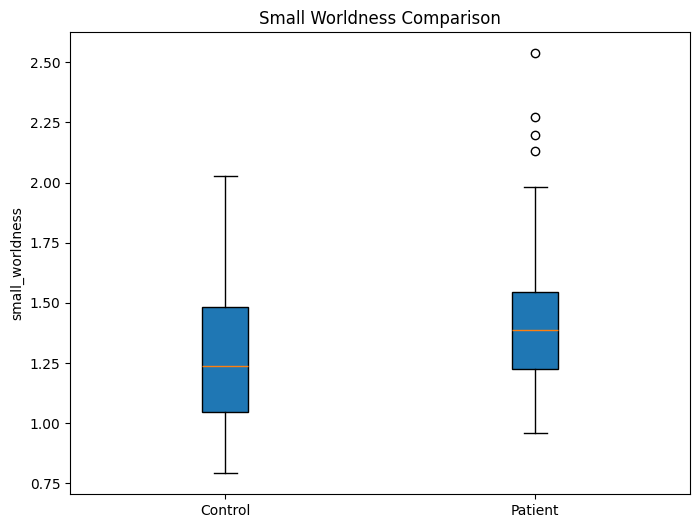

In [14]:
# Create the boxplot
plt.figure(figsize=(8, 6))
control_data = [subj.metrics[197]['pos_thresh_avg']['small_worldness'] for subj in controls_list]
patient_data = [subj.metrics[197]['pos_thresh_avg']['small_worldness'] for subj in patients_list]
plt.boxplot([control_data, patient_data], vert=True, patch_artist=True, labels=["Control", "Patient"])


# Add titles and labels
plt.title('Small Worldness Comparison')
plt.ylabel('small_worldness')
plt.show()

In [16]:
# Pretty print
import pandas as pd
# Set pandas display options to show everything in one line
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.width', None)        # Disable line wrapping
pd.set_option('display.max_colwidth', None) # Prevent truncating column

In [254]:
# pos graph
print('Positive Networks')
data = {'Metric': ['Control Mean', 'Control SD', 'Patient Mean', 'Patient SD', 'p-value (MW)']}
data_latex = {'Metric': ['Control Mean ± SD', 'Patient Mean ± SD', 'p-value']}
for key in allPosStatsKeys:
    data[key] = [dControl['pos'][key]['mean'], dControl['pos'][key]['sd'], dPatient['pos'][key]['mean'], dPatient['pos'][key]['sd'], dTests['pos'][key]['p_mw']]
    data_latex[key.replace('_', ' ')] = [dControl['pos'][key]['mean'].round(4).astype(str) + " ± " + dControl['pos'][key]['sd'].round(4).astype(str), dPatient['pos'][key]['mean'].round(4).astype(str) + " ± " + dPatient['pos'][key]['sd'].round(4).astype(str), dTests['pos'][key]['p_mw']]
# print(data)
# Convert the dictionary to a DataFrame
df = pd.DataFrame(data)
df_latex = pd.DataFrame(data_latex)
# Flip the table axes using transpose
flipped_df = df.set_index('Metric').transpose()
flipped_df2 = df_latex.set_index('Metric').transpose()
# Set pandas options to display full width
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

# print(flipped_df[0])
# Print flipped table
# flipped_df2['Metric'] = flipped_df2['Metric'].str.replace('_', r'\_', regex=False)


# # Format mean ± SD and limit decimals to 4
# df["Control Mean ± SD"] = dControl['pos'][key]['mean'].round(4).astype(str) + " ± " + dControl['pos'][key]['sd'].round(4).astype(str)
# df["Patient Mean ± SD"] = dPatient['pos'][key]['mean'].round(4).astype(str) + " ± " + dPatient['pos'][key]['sd'].round(4).astype(str)
# df['p-value'] = dTests['pos'][key]['p_mw']

# Select columns for the table
# latex_df = df[["Metric", "Control Mean ± SD", "Patient Mean ± SD", "p-value"]]
def tabletolatex(table):
    latex_table = table.to_latex(
        index=True,  # Include the index (first column)
        column_format="|l|c|c|c|",  # Format columns to align (left, center)
        caption="",  # Add a caption
        label="",  # Add a label for reference
        escape=False,  # Prevent escaping of special characters like ±
        float_format="%.4f"  # Format floats to 4 decimal places
    )

    print(
    "\\begin{table*}[h!]\n"
    "\\centering\n"
    + latex_table +
    "\\caption{}"
    "\\label{}"
    "\\end{table*}" 
    )




print('\n\n\n')
# neg graph
print('Negative Networks')
data = {'Metric': ['Control Mean', 'Control SD', 'Patient Mean', 'Patient SD', 'p-value (MW)']}
data_latex = {'Metric': ['Control Mean ± SD', 'Patient Mean ± SD', 'p-value']}
print(allNegStatsKeys)
for key in allNegStatsKeys:
    # print(key)
    data[key] = [dControl['neg'][key]['mean'], dControl['neg'][key]['sd'], dPatient['neg'][key]['mean'], dPatient['neg'][key]['sd'], dTests['neg'][key]['p_mw']]
    data_latex[key.replace('_', ' ')] = [dControl['neg'][key]['mean'].round(4).astype(str) + " ± " + dControl['neg'][key]['sd'].round(4).astype(str), dPatient['neg'][key]['mean'].round(4).astype(str) + " ± " + dPatient['neg'][key]['sd'].round(4).astype(str), dTests['neg'][key]['p_mw']]

# print(data)
# Convert the dictionary to a DataFrame
df = pd.DataFrame(data)
df_latex = pd.DataFrame(data_latex)
# Flip the table axes using transpose
flipped_df = df.set_index('Metric').transpose()
flipped_df2 = df_latex.set_index('Metric').transpose()
tabletolatex(flipped_df2)


Positive Networks




Negative Networks
dict_keys(['connectivity_strength', 'degrees_mean', 'degrees_variance', 'average_clustering', 'global_efficiency', 'average_spl', 'degree_assortativity_coefficient', 'robustness_random', 'robustness_targeted', 'small_worldness'])
\begin{table*}[h!]
\centering
\begin{tabular}{|l|c|c|c|}
\toprule
Metric & Control Mean ± SD & Patient Mean ± SD & p-value \\
\midrule
connectivity strength & 0.2024 ± 0.0735 & 0.2634 ± 0.1131 & 0.0008 \\
degrees mean & 4.3047 ± 1.8563 & 5.7083 ± 2.6867 & 0.0007 \\
degrees variance & 23.1255 ± 13.4525 & 34.1687 ± 28.827 & 0.0292 \\
average clustering & 0.0186 ± 0.0117 & 0.0113 ± 0.0093 & 0.0000 \\
global efficiency & 0.5142 ± 0.0344 & 0.4992 ± 0.0487 & 0.0469 \\
average spl & 1.9846 ± 0.3363 & 2.1779 ± 0.2723 & 0.0003 \\
degree assortativity coefficient & -0.3257 ± 0.0735 & -0.3271 ± 0.0983 & 0.8634 \\
robustness random & 18431.9425 ± 820.9404 & 18322.3653 ± 969.4189 & 0.6969 \\
robustness targeted & 9490.3082 ± 2837.232

**Help decide density threshold range for negative edges**

In [73]:
# scale = 197
max_edges = (197*196)/2
print(max_edges)
# calculate mean number of positive and negative edges for all subjects
avg_num_pos_edges = np.mean([subj.scales[197].pos.number_of_edges() for subj in subjects_list])
avg_num_neg_edges = np.mean([subj.scales[197].neg.number_of_edges() for subj in subjects_list])
print(avg_num_pos_edges, avg_num_neg_edges)

subj = subjects_list[0]
num_pos_edges_37 = subj.scales[197].pos_thresh[37].number_of_edges()
num_pos_edges_50 = subj.scales[197].pos_thresh[50].number_of_edges()
print(num_pos_edges_37, num_pos_edges_50)

# calculate threshold to get similar percentages of negative edges after thresholding
ratio_pos_37 = num_pos_edges_37/avg_num_pos_edges
ratio_pos_50 = num_pos_edges_50/avg_num_pos_edges 
print(ratio_pos_37, ratio_pos_50)

num_neg_edges_37 = ratio_pos_37 * avg_num_neg_edges
num_neg_edges_50 = ratio_pos_50 * avg_num_neg_edges 
print(num_neg_edges_37, num_neg_edges_50)

thresh_neg_37 = num_neg_edges_37/max_edges
thresh_neg_50 = num_neg_edges_50/max_edges
print(thresh_neg_37, thresh_neg_50)

19306.0
15310.328767123288 3995.671232876712
7143 9653
0.4665477867032194 0.6304894001184624
1864.171570092354 2519.2283586870353
0.09655918212433202 0.1304894001184624


**Visualization helper code**

In [43]:
# Generate edge files for visualization
def make_edge_files(scale, num_subjects=-1): 
    np_arr = np.load(f'functional connectomes/connectomes_cobre_scale_{scale}.npy')
    edges_folder=f'functional connectomes/{scale}_edges'

    if not os.path.exists(edges_folder):
        os.makedirs(edges_folder)
    if num_subjects == -1:
        num_subjects = np.shape(np_arr)[2]
    for i in range(num_subjects):
        subject = subjects_list[i]
        subjectArr = np_arr[:, :, i]
        # save to .edge file
        np.savetxt(f'{edges_folder}/{subject.id}.edge', subjectArr, fmt='%s', delimiter='\t')
        # save adjacency matrixto csv file for gephi
        with open(f'{edges_folder}/{subject.id}.csv', 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            # Write the header (empty cell + labels)
            writer.writerow([''] + [i+1 for i in range(np.shape(subjectArr)[0])])
            # Write the rows (label + data)
            for i, row in enumerate(subjectArr):
                writer.writerow([i+1] + row.tolist())

make_edge_files(197,2)


In [44]:
# Generate edge files for visualization from graphs in subject list
def make_edge_files(scale, subject, G, label='special'): 
    # np_arr = np.load(f'functional connectomes/connectomes_cobre_scale_{scale}.npy')
    subjectArr = nx.to_numpy_array(G, weight='weight')
    edges_folder=f'functional connectomes/{scale}_edges'

    if not os.path.exists(edges_folder):
        os.makedirs(edges_folder)

    # save to .edge file
    np.savetxt(f'{edges_folder}/{subject.id}-{label}.edge', subjectArr, fmt='%s', delimiter='\t')
    # save adjacency matrixto csv file for gephi
    with open(f'{edges_folder}/{subject.id}-{label}.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        # Write the header (empty cell + labels)
        writer.writerow([''] + [i+1 for i in range(np.shape(subjectArr)[0])])
        # Write the rows (label + data)
        for i, row in enumerate(subjectArr):
            writer.writerow([i+1] + row.tolist())

make_edge_files(197, subjects_list[0], subjects_list[0].scales[197].pos, 'pos')


**Comparing by 7-parcel network**

In [ ]:
all_nodes = nx.get_node_attributes(test_subj.scales[197].pos_thresh[0], 'parent')
scale_7_node_by_root = {x:[] for x in range(1,8)}

for key in scale_7_node_by_root.keys():
    for key_197 in all_nodes.keys():
        if all_nodes[key_197][-2] == str(key):
            scale_7_node_by_root[key].append(key_197)

In [155]:
# null mean values from previous calcs
patient_mean_cluster_null = 0.19978388848929135
control_mean_cluster_null = 0.22410291261526316
patient_mean_spl_null = 1.9013320321792997
control_mean_spl_null = 1.8239565006224348


#  extract graphs for each 7-parcel network
for subj in new_subjects_list[2:]:
    # subj_metrics_7parcel[subj.id] = 
    subj_graphs = subj.scales[197]

    metrics_by_7parcel = {x:[] for x in range(1,8)}

    for key in scale_7_node_by_root.keys():
        d = {}
        pos_threshold_metrics = {}
        for threshold in subj_graphs.pos_thresh.keys():
            og_thresh_graph = subj_graphs.pos_thresh[threshold]
            G_subgraph = og_thresh_graph.subgraph(scale_7_node_by_root[key]).copy()
            pos_threshold_metrics[threshold] = calc_metrics(G_subgraph)


        # neg_threshold_metrics = {}
        # for threshold in subj_graphs.neg_thresh.keys():
        #     og_thresh_graph = subj_graphs.pos_thresh[threshold]
        #     G_subgraph = og_thresh_graph.subgraph(scale_7_node_by_root[key]).copy()
        #     neg_threshold_metrics[threshold] = calc_metrics(G_subgraph)

        d['pos_thresh_avg'] = calc_metrics_avg(pos_threshold_metrics)
        # d['neg_thresh_avg'] = calc_metrics_avg(neg_threshold_metrics)

        avgs_dict = d['pos_thresh_avg']
        # print(avgs_dict)
        if subj.subject_type == 'Control':
            small_worldness = (avgs_dict['average_clustering'] * control_mean_spl_null) / (avgs_dict['average_spl'] * control_mean_cluster_null)
        elif subj.subject_type == 'Patient':
            small_worldness = (avgs_dict['average_clustering'] * patient_mean_spl_null) / (avgs_dict['average_spl'] * patient_mean_cluster_null)
        d['pos_thresh_avg']['small_worldness'] = small_worldness

        metrics_by_7parcel[key] = d
    subj.metrics_by_7parcel = metrics_by_7parcel


In [162]:
# metrics_by_7parcel[1]
print(new_subjects_list[14].metrics_by_7parcel[3])


{'pos_thresh_avg': {'connectivity_strength': 0.5429033175556169, 'degrees_mean': 2.8896993038728955, 'degrees_variance': 0.27509199421758107, 'average_clustering': 0.5052855152104413, 'global_efficiency': 0.7857142857142857, 'average_spl': 1.6919782932247271, 'degree_assortativity_coefficient': -0.202904566182498, 'robustness_random': 38.142857142857146, 'robustness_targeted': 33.07142857142857, 'small_worldness': 2.842101375339756}}


In [133]:
neg_tresh_graph = subjects_list[0].scales[197].neg_thresh[0]
print(neg_tresh_graph)
print(nx.is_connected(neg_tresh_graph))
edge_weights = [neg_tresh_graph[i][j]['weight'] for i,j in neg_tresh_graph.edges()]
max_w = max(edge_weights)
# invert weights
# initialize graph with inverted edge weights
inv_G = nx.Graph()

# add edges from original graph, with weights transformed as described above
for e,f in neg_tresh_graph.edges():
    inv_G.add_edge(e,f,weight=(2*max_w)-neg_tresh_graph[e][f]["weight"])
    
print(inv_G)
print(nx.is_connected(inv_G))


print(subjects_list[0].scales[197].neg_thresh[0])
print(nx.average_shortest_path_length(subjects_list[0].scales[197].neg_thresh[4]))
print(calc_metrics(subjects_list[0].scales[197].neg_thresh[0]))

print(subjects_list[0].metrics[197]['neg_thresh'])

Graph with 197 nodes and 1863 edges
False
Graph with 195 nodes and 1863 edges
True
Graph with 197 nodes and 1863 edges
2.0140370869159847
{'connectivity_strength': 0.2765275926801586, 'degrees': [10.32425702866454, 15.38987784258732, 8.863158379228127, 11.972121433283696, 10.882812160909879, 13.34635572004163, 7.953961446075478, 24.06441028214932, 3.8002583781554455, 16.951551545929448, 9.327531038183176, 6.600356191728805, 9.35354355507741, 8.449902856878051, 10.507495996140069, 4.00973013363291, 13.648238275696011, 8.524071327867576, 3.7255086650965836, 13.291177412697879, 12.529110877856382, 13.844382786538446, 11.729638410491397, 6.457351464098253, 13.780077626890046, 12.415051980071953, 13.885774398922143, 4.249175776379132, 17.977046898854557, 8.097039008416086, 7.143844707225668, 5.225557860801384, 5.211651575185293, 2.2025081079292566, 9.010357021967618, 4.52821840832117, 10.880292024732517, 5.10297782757841, 14.0154447484885, 2.042165378990978, 9.753544600710446, 9.69646258617

In [364]:
from scipy.stats import mannwhitneyu
from scipy.stats import permutation_test

# Positive stats
allPosStatsKeys = new_subjects_list[0].metrics[197]['pos_thresh_avg'].keys()

for parcel7key in range(1,8):
    final_stats_dict = {}
    dPatient = {'pos':{key:{} for key in allPosStatsKeys}}
    dControl = {'pos':{key:{} for key in allPosStatsKeys}}
    dTests = {'pos': {key:{} for key in allPosStatsKeys}, 'neg': {key:{} for key in allPosStatsKeys}}


    for key in allPosStatsKeys:
        patients_values = [subj.metrics_by_7parcel[parcel7key]['pos_thresh_avg'][key] for subj in patients_list]
        # print(patients_values)
        controls_values = [subj.metrics_by_7parcel[parcel7key]['pos_thresh_avg'][key] for subj in controls_list]
        dPatient['pos'][key]['mean'] = np.mean(patients_values)
        dPatient['pos'][key]['sd'] = np.std(patients_values)
        dControl['pos'][key]['mean'] = np.mean(controls_values)
        dControl['pos'][key]['sd'] = np.std(controls_values)
        stat, p_mw = mannwhitneyu(controls_values, patients_values)
        dTests['pos'][key]['u'] = stat
        dTests['pos'][key]['p_mw'] = p_mw

    print(f'Positive Networks 7-parcel ROI {parcel7key}')
    data = {'Metric': ['Control Mean', 'Control SD', 'Patient Mean', 'Patient SD', 'p-value (MW)']}
    for key in allPosStatsKeys:
        data[key] = [dControl['pos'][key]['mean'], dControl['pos'][key]['sd'], dPatient['pos'][key]['mean'], dPatient['pos'][key]['sd'], dTests['pos'][key]['p_mw']]
    # print(data)
    # Convert the dictionary to a DataFrame
    df = pd.DataFrame(data)
    # Flip the table axes using transpose
    flipped_df = df.set_index('Metric').transpose()

    # Set pandas options to display full width
    pd.set_option('display.max_rows', 500)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.width', 150)

    # Print flipped table
    print(flipped_df)

Positive Networks 7-parcel ROI 1
Metric                            Control Mean  Control SD  Patient Mean  Patient SD  p-value (MW)
connectivity_strength                 0.543525    0.074506      0.550899    0.080556      0.985802
degrees_mean                         10.129765    2.166680     10.308795    2.422818      0.882112
degrees_variance                      7.026197    3.145749      7.247129    4.544408      0.543845
average_clustering                    0.524949    0.070913      0.521585    0.086100      0.353761
global_efficiency                     0.885191    0.069945      0.886097    0.064343      0.963728
average_spl                           1.504037    0.209526      1.547444    0.199784      0.112351
degree_assortativity_coefficient     -0.036514    0.086064      0.000099    0.102751      0.020812
robustness_random                   285.558708    8.944532    286.012401    3.442469      0.578206
robustness_targeted                 276.344423   17.475699    276.444940   1

KeyError: 'small_worldness'

In [314]:
# All metrics are weighted
# Metrics dictionary is for each graph or thresholded graphs
def calc_metrics_unweighted(G):
    # print(G)
    degrees = [G.degree(node) for node in G]
    
    def connectivity_strength():
        return np.mean(edge_weights) if edge_weights else 0

    def average_clustering():
        return nx.average_clustering(G)

    def average_spl():
        # calculate weighted average shortest path
        if nx.is_connected(G):
            return nx.average_shortest_path_length(G)
        # if G not connected, find spl for largest connected component
        connected_components = nx.connected_components(G)
        largest_component = max(connected_components, key=len)
        new_G = G.subgraph(largest_component).copy()
        return(nx.average_shortest_path_length(new_G))

    def degree_assortativity_coefficient():
        return nx.degree_assortativity_coefficient(G)
    
    def largest_connected_component_size(graph):
        if len(list(nx.connected_components(graph))) == 0:
            return 0
        largest_cc = max(nx.connected_components(graph), key=len)
        return len(largest_cc)

    def robustness(attack_type):
        G_copy = G.copy()

        if attack_type == 'r':
            attack_order = list(G_copy.nodes())
            random.shuffle(attack_order)  # Randomize node order, TODO: update to true random?
        elif attack_type == 't':
            attack_order = sorted(G_copy.nodes(), key=lambda node: G_copy.degree(node), reverse=True)

        sizes = []
        for node in attack_order:
            G_copy.remove_node(node)
            largest_cc = largest_connected_component_size(G_copy)
            sizes.append(largest_cc)
            if largest_cc == 0:
                break

        nodes_removed = np.arange(len(sizes))
        return np.trapz(sizes, nodes_removed)
    
    # def small_worldness():
    #     # Calculate small worldness
    #     # print(avgs_dict)
    #     if subj.subject_type == 'Control':
    #         small_worldness = (avgs_dict['average_clustering'] * control_mean_spl_null) / (avgs_dict['average_spl'] * control_mean_cluster_null)
    #     elif subj.subject_type == 'Patient':
    #         small_worldness = (avgs_dict['average_clustering'] * patient_mean_spl_null) / (avgs_dict['average_spl'] * patient_mean_cluster_null)
    #     subj.metrics[197]['pos_thresh_avg']['small_worldness'] = small_worldness

    return {
        'connectivity_strength': connectivity_strength(),
        'degrees': degrees,
        'degrees_mean': np.mean(degrees),
        'degrees_variance': np.var(degrees),
        'average_clustering': average_clustering(),
        'global_efficiency': nx.global_efficiency(G),
        'average_spl': average_spl(),
        'degree_assortativity_coefficient': degree_assortativity_coefficient(),
        # 'small_worldness': small_worldness(),
        'robustness_random': robustness('r'),
        'robustness_targeted': robustness('t'),
    }



In [324]:
g1 = patients_list[1].scales[197].pos_thresh[0]
g2 = patients_list[2].scales[197].pos_thresh[0]
degrees_G1 = [degree for _, degree in g1.degree()]
degrees_G2 = [degree for _, degree in g2.degree()]
print("Degree distributions:")
print("G1:", degrees_G1)
print("G2:", degrees_G2)

Degree distributions:
G1: [71, 78, 80, 71, 80, 79, 80, 76, 36, 32, 88, 98, 38, 78, 84, 77, 69, 73, 98, 70, 18, 16, 81, 83, 62, 70, 77, 66, 54, 73, 75, 85, 113, 24, 29, 20, 80, 72, 56, 78, 82, 98, 101, 63, 67, 43, 74, 99, 97, 76, 65, 65, 75, 58, 73, 61, 75, 106, 114, 99, 77, 77, 71, 67, 21, 79, 96, 106, 87, 90, 89, 59, 63, 98, 26, 51, 94, 54, 53, 20, 101, 107, 66, 29, 89, 62, 59, 92, 102, 43, 115, 97, 105, 82, 76, 98, 104, 108, 72, 70, 75, 89, 113, 103, 81, 85, 57, 46, 55, 113, 84, 43, 53, 53, 73, 73, 77, 32, 84, 93, 95, 95, 121, 75, 45, 45, 84, 87, 111, 95, 91, 99, 63, 89, 74, 86, 92, 64, 51, 45, 62, 104, 124, 77, 89, 52, 106, 67, 108, 70, 40, 106, 54, 43, 18, 74, 71, 16, 92, 39, 30, 112, 114, 70, 56, 76, 45, 24, 104, 106, 106, 96, 101, 99, 25, 93, 45, 39, 50, 101, 88, 82, 75, 63, 108, 32, 30, 71, 59, 53, 70, 61, 26, 22, 57, 50, 12]
G2: [40, 47, 108, 105, 117, 125, 125, 109, 100, 108, 55, 71, 102, 56, 109, 116, 111, 85, 79, 78, 93, 102, 105, 103, 108, 100, 112, 94, 80, 108, 115, 78, 11

In [355]:
# Make unweighted graphs?
# for subj in new_subjects_list[2:]:
def make_unweighted_graph(subj):
    subj.metrics_unweighted = {}
    print(subj.id, subj.metrics_unweighted)
    subj_graphs = subj.scales[197]

    pos_threshold_metrics = {}
    for threshold in subj_graphs.pos_thresh.keys():
        G_2 = subj_graphs.pos_thresh[threshold].copy()
        for u, v, data in G_2.edges(data=True):
            data.pop('weight', None)  # Remove the weight attribute

        pos_threshold_metrics[threshold] = calc_metrics_unweighted(G_2)

    subj.metrics_unweighted['pos_thresh_avg'] = calc_metrics_avg(pos_threshold_metrics)

    avgs_dict = subj.metrics_unweighted['pos_thresh_avg']
    # print(avgs_dict)
    if subj.subject_type == 'Control':
        small_worldness = (avgs_dict['average_clustering'] * control_mean_spl_null) / (avgs_dict['average_spl'] * control_mean_cluster_null)
    elif subj.subject_type == 'Patient':
        small_worldness = (avgs_dict['average_clustering'] * patient_mean_spl_null) / (avgs_dict['average_spl'] * patient_mean_cluster_null)
    d['pos_thresh_avg']['small_worldness'] = small_worldness
    # print(subj.metrics_unweighted['pos_thresh_avg'])

    subj.metrics_unweighted['pos_thresh_avg']['small_worldness'] = small_worldness

    neg_threshold_metrics = {}
    for threshold in subj_graphs.neg_thresh.keys():
        G_2 = subj_graphs.neg_thresh[threshold].copy()
        for u, v, data in G_2.edges(data=True):
            data.pop('weight', None)  # Remove the weight attribute

        neg_threshold_metrics[threshold] = calc_metrics_unweighted(G_2)

    subj.metrics_unweighted['neg_thresh_avg'] = calc_metrics_avg(neg_threshold_metrics)
    avgs_dict = subj.metrics_unweighted['neg_thresh_avg']
    if subj.subject_type == 'Control':
        small_worldness = (avgs_dict['average_clustering'] * control_mean_spl_null) / (avgs_dict['average_spl'] * control_mean_cluster_null)
    elif subj.subject_type == 'Patient':
        small_worldness = (avgs_dict['average_clustering'] * patient_mean_spl_null) / (avgs_dict['average_spl'] * patient_mean_cluster_null)

    subj.metrics_unweighted['neg_thresh_avg']['small_worldness'] = small_worldness

with ThreadPoolExecutor(max_workers=5) as executor:
    executor.map(make_unweighted_graph, new_subjects_list)


contxxx0040086 {}
contxxx0040087 {}
szxxx0040110 {}
contxxx0040067 {}
szxxx0040072 {}
szxxx0040073 {}
szxxx0040071 {}
szxxx0040077 {}
szxxx0040075 {}
szxxx0040078 {}
szxxx0040079 {}
szxxx0040092 {}
szxxx0040094 {}
szxxx0040096 {}
szxxx0040097 {}
contxxx0040091 {}
szxxx0040099 {}
contxxx0040093 {}
contxxx0040095 {}
szxxx0040143 {}
szxxx0040145 {}
szxxx0040142 {}
contxxx0040014 {}
contxxx0040017contxxx0040019 {}
 {}
contxxx0040018 {}
szxxx0040060 {}
szxxx0040029 {}
contxxx0040054 {}
szxxx0040082 {}
szxxx0040081 {}
szxxx0040080 {}
szxxx0040085 {}
szxxx0040084 {}
szxxx0040089 {}
szxxx0040088 {}
contxxx0040024contxxx0040026 {}
 {}
contxxx0040027 {}
contxxx0040020contxxx0040023 {}
 {}
contxxx0040147 {}
contxxx0040146 {}
contxxx0040144 {}
contxxx0040141 {}
contxxx0040140 {}
szxxx0040010 {}
szxxx0040011 {}
szxxx0040012 {}
szxxx0040015 {}
szxxx0040016 {}
szxxx0040037 {}
contxxx0040123 {}
contxxx0040038 {}
contxxx0040033 {}
contxxx0040125 {}
contxxx0040031 {}
contxxx0040030 {}
contxxx0040036 {}


In [356]:
# print(patients_list[0].metrics_unweighted)
# print(patients_list[1].metrics_unweighted)
for patient in subjects_list[0:5]:
    print(patient.metrics_unweighted)

# print(len(patients_list))

{'pos_thresh_avg': {'connectivity_strength': 0.27652759268015853, 'degrees_mean': 85.2545322697607, 'degrees_variance': 579.3032801669716, 'average_clustering': 0.6257246376694031, 'global_efficiency': 0.7168675664609548, 'average_spl': 1.5687388080685503, 'degree_assortativity_coefficient': 0.17835410393918133, 'robustness_random': 19203.35714285714, 'robustness_targeted': 19191.928571428572, 'small_worldness': 3.246381768573039}, 'neg_thresh_avg': {'connectivity_strength': 0.2765275926801586, 'degrees_mean': 22.243654822335024, 'degrees_variance': 229.96589450900564, 'average_clustering': 0.0321241614545802, 'global_efficiency': 0.5170137090368774, 'average_spl': 2.0965783690628377, 'degree_assortativity_coefficient': -0.3928371453692586, 'robustness_random': 18794.3, 'robustness_targeted': 11945.1, 'small_worldness': 0.12470609350397596}}
{'pos_thresh_avg': {'connectivity_strength': 0.27652759268015853, 'degrees_mean': 85.2545322697607, 'degrees_variance': 734.7122721901769, 'averag

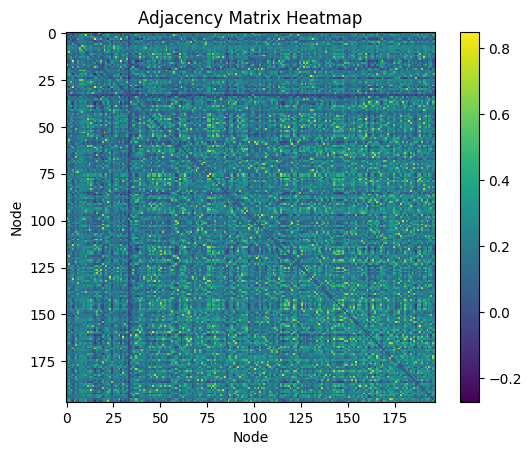

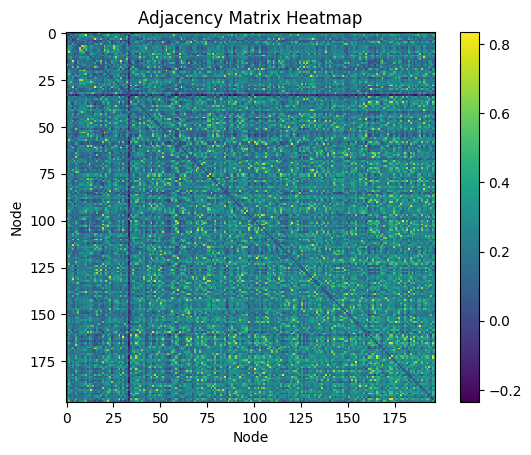

[[ 0.         -0.00580256  0.01829532 ...  0.17854372 -0.00756256
  -0.08144548]
 [-0.00580256  0.          0.2125653  ...  0.17190322  0.41547442
   0.53716901]
 [ 0.01829532  0.2125653   0.         ...  0.14587888  0.19321763
   0.16647326]
 ...
 [ 0.17854372  0.17190322  0.14587888 ...  0.          0.13966875
   0.10173854]
 [-0.00756256  0.41547442  0.19321763 ...  0.13966875  0.
   0.39501962]
 [-0.08144548  0.53716901  0.16647326 ...  0.10173854  0.39501962
   0.        ]]
[[0.         0.05082884 0.03113917 ... 0.27589538 0.0607839  0.05852036]
 [0.05082884 0.         0.13897827 ... 0.06185701 0.38501336 0.44884509]
 [0.03113917 0.13897827 0.         ... 0.14213346 0.13331038 0.12904128]
 ...
 [0.27589538 0.06185701 0.14213346 ... 0.         0.11164056 0.10060721]
 [0.0607839  0.38501336 0.13331038 ... 0.11164056 0.         0.35630605]
 [0.05852036 0.44884509 0.12904128 ... 0.10060721 0.35630605 0.        ]]


In [250]:
# Plot the heatmap using matplotlib
plt.imshow(avg_patient_mtx, cmap='viridis', interpolation='nearest')
plt.colorbar()  # Show color scale
plt.title('Adjacency Matrix Heatmap')
plt.xlabel('Node')
plt.ylabel('Node')
plt.show()

# Plot the heatmap using matplotlib
plt.imshow(avg_control_mtx, cmap='viridis', interpolation='nearest')
plt.colorbar()  # Show color scale
plt.title('Adjacency Matrix Heatmap')
plt.xlabel('Node')
plt.ylabel('Node')
plt.show()

print(avg_control_mtx)
print(avg_patient_mtx)

In [341]:
# print(patients_list[0].metrics_unweighted)
# print(patients_list[1].metrics_unweighted)
# print(patients_list[3].metrics[197]['pos_thresh_avg'])
# print(patients_list[4].metrics[197]['pos_thresh_avg'])

print(patients_list[0].metrics_by_7parcel[1])
print(patients_list[1].metrics_by_7parcel[1])

{'pos_thresh_avg': {'connectivity_strength': 0.5757693066609554, 'degrees_mean': 10.773281423027496, 'degrees_variance': 7.596506395914517, 'average_clustering': 0.5242213193103793, 'global_efficiency': 0.8901190476190477, 'average_spl': 1.589801572555803, 'degree_assortativity_coefficient': -0.0907426009637352, 'robustness_random': 287.2142857142857, 'robustness_targeted': 270.85714285714283, 'small_worldness': 3.1381179281315625}}
{'pos_thresh_avg': {'connectivity_strength': 0.4597961757138354, 'degrees_mean': 7.334853439749947, 'degrees_variance': 5.002313391772332, 'average_clustering': 0.41758219393858154, 'global_efficiency': 0.8325396825396825, 'average_spl': 1.6858155719099688, 'degree_assortativity_coefficient': -0.009139453538257753, 'robustness_random': 286.5, 'robustness_targeted': 266.42857142857144, 'small_worldness': 2.357379018066803}}


In [359]:
# Latex graph unweighted
# pos graph
from scipy.stats import mannwhitneyu
# Set pandas options to display full width
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)


# Positive stats
allPosStatsKeys = new_subjects_list[0].metrics_unweighted['pos_thresh_avg'].keys()
allNegStatsKeys = new_subjects_list[0].metrics_unweighted['neg_thresh_avg'].keys()

final_stats_dict = {}
dPatient = {'pos':{key:{} for key in allPosStatsKeys}, 'neg':{key:{} for key in allNegStatsKeys}}
# dPatientNeg = {key:{} for key in allNegStatsKeys}
dControl = {'pos':{key:{} for key in allPosStatsKeys}, 'neg':{key:{} for key in allNegStatsKeys}}
# dControlNeg = {key:{} for key in allNegStatsKeys}
dTests = {'pos': {key:{} for key in allPosStatsKeys}, 'neg': {key:{} for key in allPosStatsKeys}}


for key in allPosStatsKeys:
    patients_values = [subj.metrics_unweighted['pos_thresh_avg'][key] for subj in patients_list]
    # print(patients_values)
    controls_values = [subj.metrics_unweighted['pos_thresh_avg'][key] for subj in controls_list]
    # print(controls_values)
    dPatient['pos'][key]['mean'] = np.mean(patients_values)
    dPatient['pos'][key]['sd'] = np.std(patients_values)
    dControl['pos'][key]['mean'] = np.mean(controls_values)
    dControl['pos'][key]['sd'] = np.std(controls_values)
    stat, p_mw = mannwhitneyu(controls_values, patients_values)
    dTests['pos'][key]['u'] = stat
    dTests['pos'][key]['p_mw'] = p_mw


for key in allNegStatsKeys:
    patients_values = [subj.metrics_unweighted['neg_thresh_avg'][key] for subj in patients_list]
    controls_values = [subj.metrics_unweighted['neg_thresh_avg'][key] for subj in controls_list]
    dPatient['neg'][key]['mean'] = np.mean(patients_values)
    dPatient['neg'][key]['sd'] = np.std(patients_values)
    dControl['neg'][key]['mean'] = np.mean(controls_values)
    dControl['neg'][key]['sd'] = np.std(controls_values)
    stat, p_mw = mannwhitneyu(controls_values, patients_values)
    dTests['neg'][key]['u'] = stat
    dTests['neg'][key]['p_mw'] = p_mw

# Print df and latex
def tabletolatex(table):
    latex_table = table.to_latex(
        index=True,  # Include the index (first column)
        column_format="|l|c|c|c|",  # Format columns to align (left, center)
        caption="",  # Add a caption
        label="",  # Add a label for reference
        escape=False,  # Prevent escaping of special characters like ±
        float_format="%.4f"  # Format floats to 4 decimal places
    )

    print(
    "\\begin{table*}[h!]\n"
    "\\centering\n"
    + latex_table +
    "\\caption{}"
    "\\label{}"
    "\\end{table*}" 
    )


# pos graph
print('Positive Networks')
data = {'Metric': ['Control Mean', 'Control SD', 'Patient Mean', 'Patient SD', 'p-value (MW)']}
data_latex = {'Metric': ['Control Mean ± SD', 'Patient Mean ± SD', 'p-value']}
for key in allPosStatsKeys:
    data[key] = [dControl['pos'][key]['mean'], dControl['pos'][key]['sd'], dPatient['pos'][key]['mean'], dPatient['pos'][key]['sd'], dTests['pos'][key]['p_mw']]
    data_latex[key.replace('_', ' ')] = [dControl['pos'][key]['mean'].round(4).astype(str) + " ± " + dControl['pos'][key]['sd'].round(4).astype(str), dPatient['pos'][key]['mean'].round(4).astype(str) + " ± " + dPatient['pos'][key]['sd'].round(4).astype(str), dTests['pos'][key]['p_mw']]
df = pd.DataFrame(data)
df_latex = pd.DataFrame(data_latex)
# Flip the table axes using transpose
flipped_df = df.set_index('Metric').transpose()
flipped_df2 = df_latex.set_index('Metric').transpose()
tabletolatex(flipped_df2)

print('\n\n\n')
# neg graph
print('Negative Networks')
data = {'Metric': ['Control Mean', 'Control SD', 'Patient Mean', 'Patient SD', 'p-value (MW)']}
data_latex = {'Metric': ['Control Mean ± SD', 'Patient Mean ± SD', 'p-value']}
print(allNegStatsKeys)
for key in allNegStatsKeys:
    # print(key)
    data[key] = [dControl['neg'][key]['mean'], dControl['neg'][key]['sd'], dPatient['neg'][key]['mean'], dPatient['neg'][key]['sd'], dTests['neg'][key]['p_mw']]
    data_latex[key.replace('_', ' ')] = [dControl['neg'][key]['mean'].round(4).astype(str) + " ± " + dControl['neg'][key]['sd'].round(4).astype(str), dPatient['neg'][key]['mean'].round(4).astype(str) + " ± " + dPatient['neg'][key]['sd'].round(4).astype(str), dTests['neg'][key]['p_mw']]

# print(data)
# Convert the dictionary to a DataFrame
df = pd.DataFrame(data)
df_latex = pd.DataFrame(data_latex)
# Flip the table axes using transpose
flipped_df = df.set_index('Metric').transpose()
flipped_df2 = df_latex.set_index('Metric').transpose()
tabletolatex(flipped_df2)




Positive Networks
\begin{table*}[h!]
\centering
\begin{tabular}{|l|c|c|c|}
\toprule
Metric & Control Mean ± SD & Patient Mean ± SD & p-value \\
\midrule
connectivity strength & 0.2765 ± 0.0 & 0.2765 ± 0.0 & 1.0000 \\
degrees mean & 85.2545 ± 0.0 & 85.2545 ± 0.0 & 1.0000 \\
degrees variance & 911.705 ± 319.5578 & 818.7838 ± 350.4983 & 0.0554 \\
average clustering & 0.6776 ± 0.0301 & 0.6742 ± 0.0305 & 0.5077 \\
global efficiency & 0.7115 ± 0.0057 & 0.7132 ± 0.0045 & 0.0349 \\
average spl & 1.5911 ± 0.0217 & 1.5881 ± 0.0236 & 0.2050 \\
degree assortativity coefficient & 0.1807 ± 0.072 & 0.2138 ± 0.1061 & 0.0808 \\
robustness random & 19144.7407 ± 86.1529 & 19177.3274 ± 44.8085 & 0.0073 \\
robustness targeted & 19037.0793 ± 194.9149 & 19117.7659 ± 104.3388 & 0.0031 \\
small worldness & 3.4652 ± 0.1201 & 4.0393 ± 0.1386 & 0.0000 \\
\bottomrule
\end{tabular}
\caption{}\label{}\end{table*}




Negative Networks
dict_keys(['connectivity_strength', 'degrees_mean', 'degrees_variance', 'average_c

In [376]:
# Latex graph 7-parcellation
# pos graph
# Set pandas options to display full width
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

for subj in new_subjects_list:
    if 'small_worldness' not in subj.metrics_by_7parcel[7]['pos_thresh_avg'].keys():
        print(subj.id)
        print(subj.index)

# Positive stats
for parcel7key in range(1,8):
    allPosStatsKeys = new_subjects_list[0].metrics_by_7parcel[parcel7key]['pos_thresh_avg'].keys()

    final_stats_dict = {}
    dPatient = {'pos':{key:{} for key in allPosStatsKeys}, 'neg':{key:{} for key in allNegStatsKeys}}
    # dPatientNeg = {key:{} for key in allNegStatsKeys}
    dControl = {'pos':{key:{} for key in allPosStatsKeys}, 'neg':{key:{} for key in allNegStatsKeys}}
    # dControlNeg = {key:{} for key in allNegStatsKeys}
    dTests = {'pos': {key:{} for key in allPosStatsKeys}, 'neg': {key:{} for key in allPosStatsKeys}}


    for key in allPosStatsKeys:
        patients_values = [subj.metrics_by_7parcel[parcel7key]['pos_thresh_avg'][key] for subj in patients_list]
        # print(patients_values)
        controls_values = [subj.metrics_by_7parcel[parcel7key]['pos_thresh_avg'][key] for subj in controls_list]
        # print(controls_values)
        dPatient['pos'][key]['mean'] = np.mean(patients_values)
        dPatient['pos'][key]['sd'] = np.std(patients_values)
        dControl['pos'][key]['mean'] = np.mean(controls_values)
        dControl['pos'][key]['sd'] = np.std(controls_values)
        stat, p_mw = mannwhitneyu(controls_values, patients_values)
        dTests['pos'][key]['u'] = stat
        dTests['pos'][key]['p_mw'] = p_mw


    # pos graph
    print(f'Positive Networks {parcel7key}')
    data = {'Metric': ['Control Mean', 'Control SD', 'Patient Mean', 'Patient SD', 'p-value (MW)']}
    data_latex = {'Metric': ['Control Mean ± SD', 'Patient Mean ± SD', 'p-value']}
    for key in allPosStatsKeys:
        data[key] = [dControl['pos'][key]['mean'], dControl['pos'][key]['sd'], dPatient['pos'][key]['mean'], dPatient['pos'][key]['sd'], dTests['pos'][key]['p_mw']]
        data_latex[key.replace('_', ' ')] = [dControl['pos'][key]['mean'].round(4).astype(str) + " ± " + dControl['pos'][key]['sd'].round(4).astype(str), dPatient['pos'][key]['mean'].round(4).astype(str) + " ± " + dPatient['pos'][key]['sd'].round(4).astype(str), dTests['pos'][key]['p_mw']]
    df = pd.DataFrame(data)
    df_latex = pd.DataFrame(data_latex)
    # Flip the table axes using transpose
    flipped_df = df.set_index('Metric').transpose()
    flipped_df2 = df_latex.set_index('Metric').transpose()
    tabletolatex(flipped_df2)


Positive Networks 1
\begin{table*}[h!]
\centering
\begin{tabular}{|l|c|c|c|}
\toprule
Metric & Control Mean ± SD & Patient Mean ± SD & p-value \\
\midrule
connectivity strength & 0.5435 ± 0.0745 & 0.5509 ± 0.0806 & 0.9858 \\
degrees mean & 10.1298 ± 2.1667 & 10.3088 ± 2.4228 & 0.8821 \\
degrees variance & 7.0262 ± 3.1457 & 7.2471 ± 4.5444 & 0.5438 \\
average clustering & 0.5249 ± 0.0709 & 0.5216 ± 0.0861 & 0.3538 \\
global efficiency & 0.8852 ± 0.0699 & 0.8861 ± 0.0643 & 0.9637 \\
average spl & 1.504 ± 0.2095 & 1.5474 ± 0.1998 & 0.1124 \\
degree assortativity coefficient & -0.0365 ± 0.0861 & 0.0001 ± 0.1028 & 0.0208 \\
robustness random & 285.5587 ± 8.9445 & 286.0124 ± 3.4425 & 0.5782 \\
robustness targeted & 276.3444 ± 17.4757 & 276.4449 ± 11.7467 & 0.9606 \\
small worldness & 2.9074 ± 0.6276 & 3.2976 ± 0.8652 & 0.0121 \\
\bottomrule
\end{tabular}
\caption{}\label{}\end{table*}
Positive Networks 2
\begin{table*}[h!]
\centering
\begin{tabular}{|l|c|c|c|}
\toprule
Metric & Control Mean 

In [375]:

subj = [x for x in new_subjects_list if x.id == 'szxxx0040049'][0]
avgs_dict = subj.metrics_by_7parcel[7]['pos_thresh_avg']
small_worldness = (avgs_dict['average_clustering'] * patient_mean_spl_null) / (avgs_dict['average_spl'] * patient_mean_cluster_null)
# szxxx0040049

subj.metrics_by_7parcel[7]['pos_thresh_avg']['small_worldness'] = small_worldness

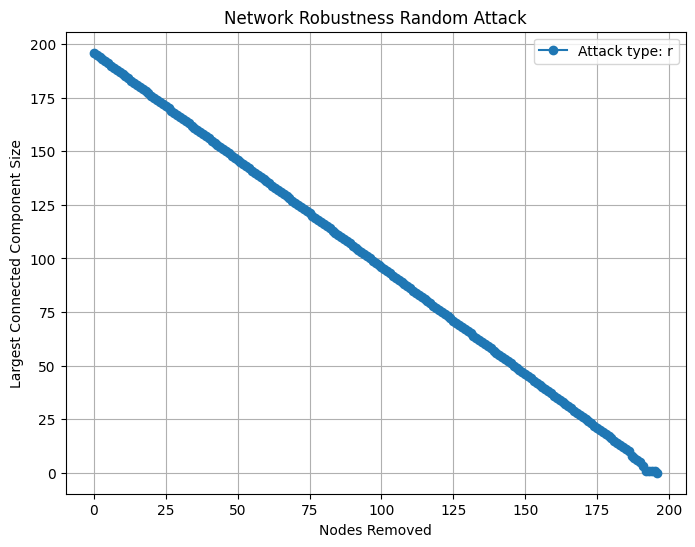

19196.0

In [ ]:
def robustness_plot(attack_type, G):
    def largest_connected_component_size(graph):
        if len(list(nx.connected_components(graph))) == 0:
            return 0
        largest_cc = max(nx.connected_components(graph), key=len)
        return len(largest_cc)
    
    G_copy = G.copy()

    if attack_type == 'r':
        attack_order = list(G_copy.nodes())
        np.random.shuffle(attack_order)  # Randomize node order
    elif attack_type == 't':
        attack_order = sorted(G_copy.nodes(), key=lambda node: G_copy.degree(node), reverse=True)

    sizes = []
    for node in attack_order:
        G_copy.remove_node(node)
        largest_cc = largest_connected_component_size(G_copy)
        sizes.append(largest_cc)
        if largest_cc == 0:
            break

    nodes_removed = np.arange(len(sizes))
    # Plot the robustness chart
    plt.figure(figsize=(8, 6))
    plt.plot(nodes_removed, sizes, label=f"Attack type: {attack_type}", marker="o")
    plt.xlabel("Nodes Removed")
    plt.ylabel("Largest Connected Component Size")
    plt.title("Network Robustness Random Attack")
    plt.legend()
    plt.grid()
    plt.show()

    # Return the robustness metric
    return np.trapz(sizes, nodes_removed)

# Example usage
robustness_plot('r', patients_list[1].scales[197].pos_thresh[13])
